In [1]:
import yt
import numpy as np
from scipy import *
import yt.units as u

In [2]:
%matplotlib inline
import pylab as plt

In [3]:
my_header =  ['raw_density', 'x-velocity','y-velocity','z-velocity', 'pressure_nt',
                  'raw_pressure','metallicity','ref','H','E','H+','HE','HE+','HE++','H-','H2','H2+']

In [4]:
def density_alias(field, data):
    return data.ds.arr(data['raw_density'], 'code_mass/code_length**3')
def pressure_alias(field, data):
    return data.ds.arr(data['raw_pressure'], 'code_mass/code_time**2/code_length')

In [5]:
ds = yt.load("output_00028/info_00028.txt",fields=my_header)

yt : [INFO     ] 2018-07-23 09:52:15,627 Parameters: current_time              = 3.17276944493
yt : [INFO     ] 2018-07-23 09:52:15,628 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-07-23 09:52:15,630 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-07-23 09:52:15,632 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-07-23 09:52:15,636 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-07-23 09:52:15,637 Parameters: current_redshift          = 5.99989573952965
yt : [INFO     ] 2018-07-23 09:52:15,638 Parameters: omega_lambda              = 0.691999971866608
yt : [INFO     ] 2018-07-23 09:52:15,639 Parameters: omega_matter              = 0.30799999833107
yt : [INFO     ] 2018-07-23 09:52:15,641 Parameters: hubble_constant           = 0.677900009155273


In [6]:
ds.add_field('density', function=density_alias, units='g/cm**3',
             sampling_type='cell',force_override=True)
ds.add_field('pressure', function=pressure_alias, units='g/cm/s**2',
             sampling_type='cell',force_override=True)

In [7]:
center_init = [ 0.53095117,  0.51029149,  0.50401411]
los_vec = [ 0.9,    0.3082207, 0.3082207]
mms = 512
size = 0.00166389148881
size_kpc = 7.0
up_vec = [ 0.3082207,  0.9, 0.3082207]

yt : [INFO     ] 2018-07-23 09:52:48,702 Projection completed
yt : [INFO     ] 2018-07-23 09:52:48,703 xlim = 0.004014 1.004014
yt : [INFO     ] 2018-07-23 09:52:48,704 ylim = 0.030951 1.030951
yt : [INFO     ] 2018-07-23 09:52:48,706 xlim = 0.004014 1.004014
yt : [INFO     ] 2018-07-23 09:52:48,706 ylim = 0.030951 1.030951
yt : [INFO     ] 2018-07-23 09:52:48,709 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2018-07-23 09:52:50,085 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



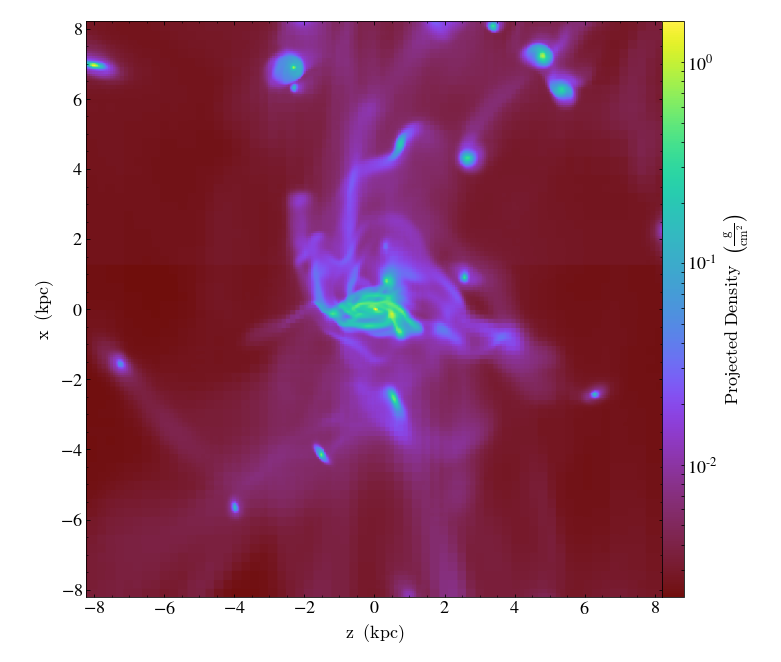

In [8]:
p = yt.ProjectionPlot(ds,'y','density',center_init)
#p.annotate_grids()
p.zoom(256)

In [9]:
# Thomson scattering cross section
sigma_t = yt.YTQuantity(6.6524e-25,'cm**2')

In [50]:
# random sampling of ray direction
num_rays = 100
rtheta = np.arccos(1-2*np.random.rand(num_rays))
rphi = np.random.rand(num_rays)*2*pi

In [51]:
# radius of the ray path
radius = 4*u.kpc
r_norm = np.array(radius/ds.domain_width.in_units('kpc')[0])

In [52]:
# loop to sample light rays
tau = []
dcol = []
for i in range(num_rays):
    theta = rtheta[i]
    phi = rphi[i]
    endpos = center_init + r_norm*[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(phi)]
    ray = ds.ray(center_init, endpos)
    a=ray['t']
    dens_col=np.sum(ray['density']*ray['dts'])/u.mass_hydrogen * radius
    tau.append(dens_col*sigma_t)
    dcol.append(dens_col)
    #print(col_dens.in_cgs())
tau = yt.YTArray(tau)
dcol = yt.YTArray(dcol)

In [60]:
tau.in_cgs()

YTArray([ 0.1905229 ,  0.26662017,  0.04982226,  0.08520753,  0.12106261,
        0.12278757,  0.31153724,  0.0435996 ,  0.24029424,  1.6165916 ,
        0.12746015,  0.16099349,  0.20290631,  0.31834437,  0.33321066,
        0.6883931 ,  0.10346833,  0.12694741,  0.37547536,  0.36969076,
        0.07702731,  0.40374102,  0.19724607,  0.2474424 ,  0.10446346,
        0.62338837,  0.14899509,  0.05798106,  0.81320553,  0.14049788,
        0.08465099,  0.08081884,  0.06274692,  0.66824922,  0.28237093,
        0.14117591,  0.14540449,  0.04754662,  0.15827177,  0.04476068,
        0.3716499 ,  0.04420517,  0.19691884,  0.06028221,  0.1111889 ,
        0.04436788,  0.33316673,  0.09988445,  0.51492826,  0.0541712 ,
        0.2179264 ,  0.27345224,  0.13922331,  0.14922094,  0.10414285,
        0.2801508 ,  0.11230656,  0.26485283,  0.05393075,  0.51558319,
        0.57829995,  0.07180915,  0.04307447,  0.25355156,  0.39426164,
        0.22267057,  1.32902431,  0.04235254,  0.1148778 ,  0.

yt : [INFO     ] 2018-07-23 10:04:04,943 Projection completed
yt : [INFO     ] 2018-07-23 10:04:04,944 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-07-23 10:04:04,945 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-07-23 10:04:04,947 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-07-23 10:04:04,948 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-07-23 10:04:04,951 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2018-07-23 10:04:05,170 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



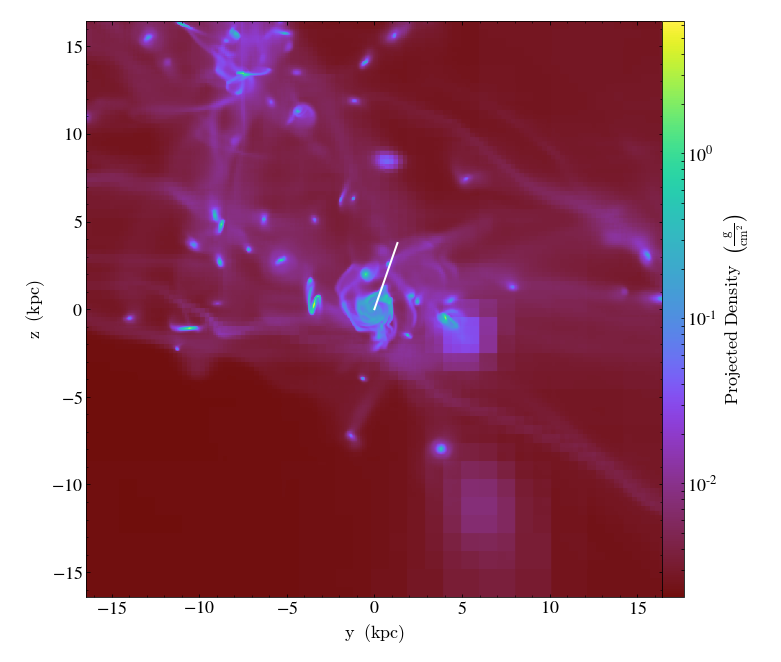

In [54]:
p = yt.ProjectionPlot(ds,'x','density',center_init)
#p = yt.SlicePlot(ds, 'y', 'density',center_init)
p.annotate_ray(ray)
p.zoom(128)

In [55]:
# column density distribution
p,bins = np.histogram(log10(dcol.in_cgs()))
bin_center = (bins[:-1]+bins[1:])/2.

Text(0,0.5,'count')

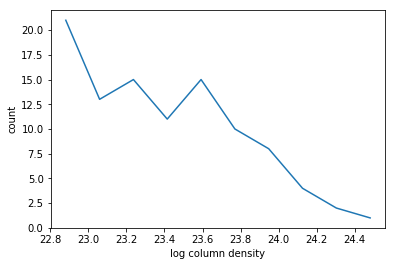

In [56]:
plt.plot(bin_center,p)
plt.xlabel(r'log column density')
plt.ylabel('count')

In [59]:
ray['dts']

YTArray([ 0.02142881,  0.01230095,  0.00042247,  0.02127827,  0.01287396,
        0.02112773,  0.0130245 ,  0.02097719,  0.00798856,  0.00518649,
        0.02082665,  0.01332558,  0.02067611,  0.01347613,  0.02052556,
        0.00367616,  0.00995051,  0.02037502,  0.01377721,  0.02022448,
        0.01392775,  0.0194377 ,  0.00063623,  0.01407829,  0.0199234 ,
        0.01422884,  0.01977285,  0.01437938,  0.01932123,  0.01467368,
        0.00494863,  0.01452992,  0.01947177,  0.01468046,  0.02474067,
        0.02424257,  0.01902015,  0.04928432,  0.01871906,  0.03212001,
        0.00143649,  0.00036649,  0.00552926,  0.00264231,  0.00585812,
        0.00267994,  0.00582048,  0.00189306,  0.00082451,  0.00578285,
        0.00275521,  0.00574521,  0.00279285,  0.00570757,  0.00081497,
        0.00201552,  0.00566994,  0.00286812,  0.0056323 ,  0.00290575,
        0.00533154,  0.00026313,  0.00294339,  0.00555703,  0.00298102,
        0.0055194 ,  0.00301866,  0.00414053,  0.00134123,  0.